In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Data generation

In [128]:
x_dim = 5 # dimension of observations
freq = 0.01 # frequency of class 2 samples
mu_1 = 5*np.random.randn(x_dim,1) # mean of class 1
mu_2 = 5*np.random.randn(x_dim,1) # mean of class 2
sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T
samples = 100000 # number of data points

In [129]:
class_1 = mu_1 + sig@np.random.randn(x_dim,int(samples*(1-freq)))
class_2 = mu_2 + sig@np.random.randn(x_dim,int(samples*freq))

In [130]:
X = np.concatenate((class_1,class_2),axis=1)
Y = np.zeros((2,samples)); Y[0,:int(samples*(1-freq))] = 1; Y[1,-int(samples*freq):] = 1
idx = np.random.permutation(samples)
X = X[:,idx]
Y = Y[:,idx]

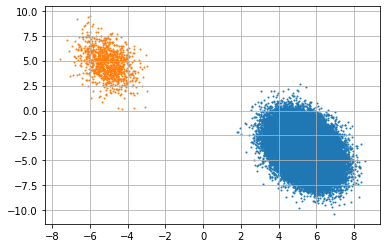

In [131]:
plt.scatter(class_1[0],class_1[1],s=1)
plt.scatter(class_2[0],class_2[1],s=1)
plt.grid()
plt.show()

### Optimal solution

In [132]:
w_opt = np.linalg.inv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)

In [133]:
obj_opt = (w_opt.T@(mu_1-mu_2))**2

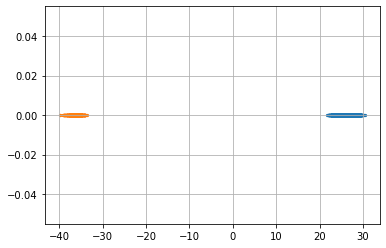

In [134]:
plt.scatter(w_opt.T@class_1,np.zeros((w_opt.T@class_1).shape),s=5)
plt.scatter(w_opt.T@class_2,np.zeros((w_opt.T@class_2).shape),s=5)
plt.grid()
plt.show()

### Offline algorithm

In [153]:
eta = 0.001; gam = 10000*eta; iters = 10000

In [154]:
w = np.random.randn(x_dim,1)/np.sqrt(x_dim)
l = 1

obj = np.zeros(iters)
err = np.zeros(iters)

for i_iter in range(iters):
    w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
    l = l + gam*(w.T@Sigma@w - 1)
    obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
    err[i_iter] = (obj_opt - obj[i_iter])/obj_opt

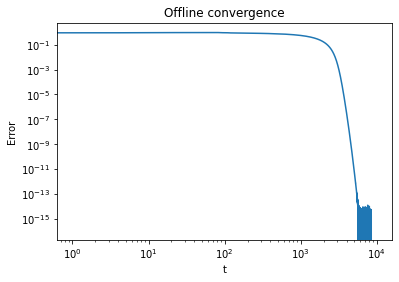

In [155]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Offline convergence")
plt.show()

### Online algorithm

In [162]:
def eta(t):
    return 1e-4/(1+1e-4*t)

gam = 1000; epochs = 10; iters = epochs*samples

In [163]:
w = np.random.randn(x_dim)/np.sqrt(x_dim)
l = 1

obj = np.zeros(iters)
err = np.zeros(iters)

mu_1 = np.zeros(x_dim)
mu_2 = np.zeros(x_dim)

a = 0.5
b = 0.5

start_time = time.time()

for i_epoch in range(epochs):
    
    print(f'Epoch {i_epoch+1} of {epochs}:')
        
    idx = np.random.permutation(samples)
    
    for i_sample in range(samples):
        
        i_iter = i_epoch*samples + i_sample
        
        t = i_iter + 1
        
        x = X[:,idx[i_sample]]
        y = Y[:,idx[i_sample]]
        
        z = w.T@x

        a = max(a + (y[0]-a)/t,1e-5)
        b = max(b + (y[1]-b)/t,1e-5)
        
        mu_1 += ((y[0]/a)*x - mu_1)/t
        mu_2 += ((y[1]/b)*x - mu_2)/t

        mu = mu_1*y[0] + mu_2*y[1]
        nu = w.T@mu
        
        step = eta(t)

        w += step*(y[0]/a - y[1]/b)*x - step*l*(z-nu)*(x-mu)
        l += gam*step*((z-nu)**2 - 1)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt
        
    print(f'Elapsed time: {time.time()-start_time} seconds')
    print(f'Error: {err[i_iter]}')

Epoch 1 of 10:
Elapsed time: 3.3438611030578613 seconds
Error: 0.061630492602659986
Epoch 2 of 10:
Elapsed time: 6.705391883850098 seconds
Error: 0.02034758782556067
Epoch 3 of 10:
Elapsed time: 10.066795110702515 seconds
Error: 0.01066167284160601
Epoch 4 of 10:
Elapsed time: 13.407502889633179 seconds
Error: 0.012477544751773213
Epoch 5 of 10:
Elapsed time: 16.74834370613098 seconds
Error: 0.005994293650378125
Epoch 6 of 10:
Elapsed time: 20.064230918884277 seconds
Error: 0.004577257567588407
Epoch 7 of 10:
Elapsed time: 23.379560947418213 seconds
Error: 0.0036224523831099122
Epoch 8 of 10:
Elapsed time: 26.709561824798584 seconds
Error: 0.003786280568941685
Epoch 9 of 10:
Elapsed time: 30.02547311782837 seconds
Error: 0.003114591610957079
Epoch 10 of 10:
Elapsed time: 33.35364890098572 seconds
Error: 0.002830893327227126


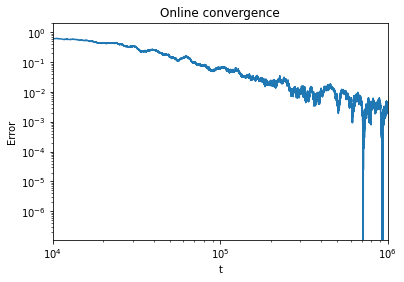

In [164]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e4,iters)
plt.title("Online convergence")
plt.show()

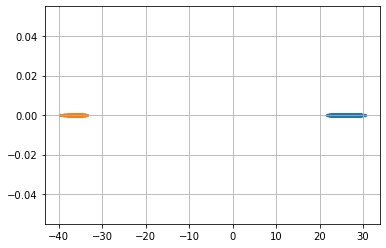

In [165]:
plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
plt.grid()
plt.show()

### Online algorithm for sparse class 2 samples

In [168]:
def eta(t):
    return 1e-4/(1+1e-4*t)

gam = 1000; epochs = 10; iters = epochs*samples

In [169]:
w = np.random.randn(x_dim)/np.sqrt(x_dim)
l = 1

obj = np.zeros(iters)
err = np.zeros(iters)

mu = np.zeros(x_dim)

b = 0.5

start_time = time.time()

for i_epoch in range(epochs):
    
    print(f'Epoch {i_epoch+1} of {epochs}:')
        
    idx = np.random.permutation(samples)
    
    for i_sample in range(samples):
        
        i_iter = i_epoch*samples + i_sample
        
        t = i_iter + 1
        
        x = X[:,idx[i_sample]]
        y = Y[:,idx[i_sample]]
        
        z = w.T@x

        b = max(b + (y[1]-b)/t,1e-5)
        
        mu += (x - mu)/t
        nu = w.T@mu
        
        step = eta(t)

        w += step*(x - l*(z-nu)*(x-mu)) - step*y[1]*x/b
        l += gam*step*((z-nu)**2 - 1)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt
        
    print(f'Elapsed time: {time.time()-start_time} seconds')
    print(f'Error: {err[i_iter]}')

Epoch 1 of 10:
Elapsed time: 2.511451005935669 seconds
Error: 0.5565625874130137
Epoch 2 of 10:
Elapsed time: 5.023328065872192 seconds
Error: 0.10553359459203701
Epoch 3 of 10:
Elapsed time: 7.539638042449951 seconds
Error: 0.14397234884342944
Epoch 4 of 10:
Elapsed time: 10.065546035766602 seconds
Error: 0.12542135881334177
Epoch 5 of 10:
Elapsed time: 12.583182096481323 seconds
Error: 0.03304131332239965
Epoch 6 of 10:
Elapsed time: 15.08685302734375 seconds
Error: 0.0296317655955881
Epoch 7 of 10:
Elapsed time: 17.599776029586792 seconds
Error: 0.028263084438207613
Epoch 8 of 10:
Elapsed time: 20.09980607032776 seconds
Error: 0.06752933482525036
Epoch 9 of 10:
Elapsed time: 22.61093521118164 seconds
Error: 0.01958412634278929
Epoch 10 of 10:
Elapsed time: 25.119469165802002 seconds
Error: 0.03205939010577684


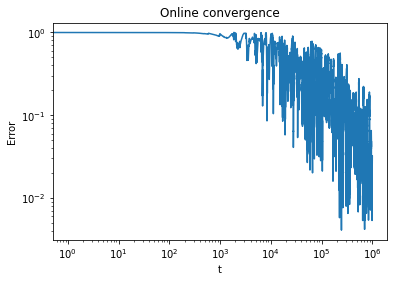

In [170]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
# plt.xlim(1e4,iters)
plt.title("Online convergence")
plt.show()

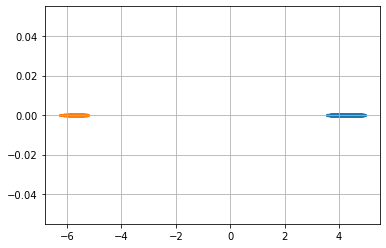

In [171]:
plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
plt.grid()
plt.show()